In [1]:
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyIEEM.models.utils import initialize_model

In [2]:
country = 'SWE'
spatial = False
age_classes = pd.IntervalIndex.from_tuples([(0,5),(5,10),(10,15),(15,20),(20,25),(25,30),(30,35),(35,40),(40,45),(45,50),(50,55),(55,60),(60,65),(65,70),(70,75),(75,80),(80,120)], closed='left')

In [5]:
def max_utility_function(I_star, alpha, beta, gamma, delta, psi, m, RL, l0):
    max_work_actual = (((1-alpha)*m*l0*(1-RL)*(1-psi))/(alpha*beta*I_star**beta))**(1/(beta-1))
    max_work_effective = (((1-alpha)*m*l0*(1-RL)*psi)/(alpha*beta*I_star**delta))**(1/(delta-1))
    l_i = l0*(RL + (1-RL)*((1-psi)*max_work_actual + psi*max_work_effective))
    max_leisure =(((1-alpha)*m*l_i*0.2)/(alpha*gamma*I_star**gamma))**(1/(gamma-1))
    return min(max_work_actual,1), min(max_work_effective,1), min(max_leisure, 1)

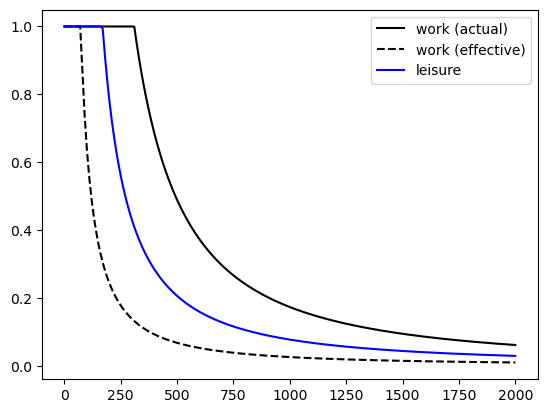

In [42]:
I_star = np.linspace(1,2000,201)

RL = 0.90
alpha = 1e-9
beta = 3
gamma = 3.5
delta = 3.5
psi = 0.1
l0 = 1
m = 1

work_actual = []
work_effective = []
leisure = []
for I in I_star:
    w_act, w_eff, l = max_utility_function(I, alpha, beta, gamma, delta, psi, m, RL, l0)
    work_actual.append(w_act)
    work_effective.append(w_eff)
    leisure.append(l)

fig,ax=plt.subplots()
ax.plot(I_star, work_actual, color='black', label='work (actual)')
ax.plot(I_star, work_effective, color='black', linestyle='--', label='work (effective)')
ax.plot(I_star, leisure, color='blue', label='leisure')
#ax.plot(I_star, leisure_actual, color='blue', linestyle='--', label='leisure')
ax.legend()
plt.show()
plt.close()

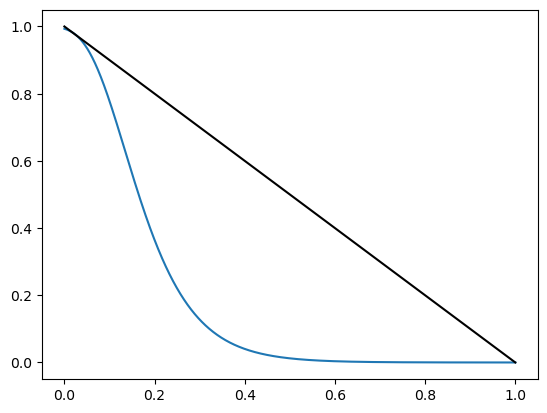

In [36]:
# parameters
alpha = 5
beta = 12
# model
x = np.linspace(0,1,1001)
y = 1-np.exp(-alpha*np.exp(-beta*x))

# visualize
fig,ax=plt.subplots()
ax.plot(x, y)
ax.plot(x, 1-x, color='black')
#ax.set_xlim([0,1])
#ax.set_ylim([0,1])
plt.show()
plt.close()

In [29]:
simulation_start = '2020-01-30'
model = initialize_model(country, age_classes, spatial, simulation_start, contact_type='absolute_contacts')

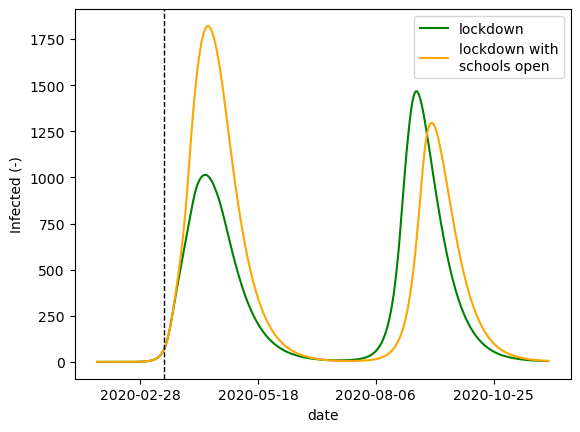

In [30]:
fig,ax = plt.subplots()

model.parameters['tau'] = 31
model.parameters['beta'] = 0.027
model.parameters['amplitude'] = 0

# economic lockdown, schools closed, preventive measures, social restrictions
model.parameters['economic_closures'].loc[slice(None)] = 1
out = model.sim([simulation_start, '2020-12-01'])
ax.plot(out.date, out.Hin.sum(dim=['age_class', 'spatial_unit']), color='green', label='lockdown')

# economic lockdown, schools open, preventive measures, social restrictions
model.parameters['economic_closures'].loc['P85'] = 0
out = model.sim([simulation_start, '2020-12-01'])
ax.plot(out.date, out.Hin.sum(dim=['age_class', 'spatial_unit']), 'orange', label='lockdown with\nschools open')

# do-nothing
#model.parameters['social_restrictions'] = 0
#model.parameters['economic_closures'].loc[slice(None)] = 0
#out = model.sim([simulation_start, '2020-12-01'])
#ax.plot(out.date, out.Hin.sum(dim=['age_class', 'spatial_unit']), color='red', label='do nothing')

ax.legend()

ax.axvline(x=datetime(2020, 3, 15), color='black', linestyle='--', linewidth=1)
ax.set_xlabel('date')
ax.set_ylabel('Infected (-)')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.show()
plt.close()

In [118]:
def compute_beta(R0, delta, gamma, s, N, demography):
    beta_i = R0/(s*(delta+gamma)*np.expand_dims(np.sum(N, axis=0),axis=1))
    return sum(np.squeeze(beta_i)*demography/sum(demography))

In [121]:
N = np.squeeze(model.parameters['N']['other'] + model.parameters['G']*model.parameters['N']['work'])
demography = pd.read_csv(f'../data/interim/epi/demographic/age_structure_{country}_2019.csv', index_col=[0, 1]).groupby(by='age').sum().squeeze()
demography = demography.groupby(pd.cut(demography.index.values, age_classes)).sum()
compute_beta(2.75, model.parameters['delta'], model.parameters['gamma'], model.parameters['s'], N, demography.values)

0.02733129308543969